# Machine Learning 


India is hosting the ICC World Cup 2023, but one match has drawn attention for a different reason: **poor air quality index (AQI)** in Delhi. The capital city experiences poor AQI during every winter season, and this year was no exception. A match between Bangladesh and Sri Lanka held in Delhi raised eyebrows again for the high air pollution levels. Similarly, New York City experienced alarming air quality levels this year due to wildfires in Canada.

As a data-driven Business Analyst, I decided to focus on the various medical causes of deaths in the United States. Instead of analyzing trends, patterns, and visualizations, I built a machine learning model to predict deaths caused by diseases such as **diabetes mellitus, Alzheimer's disease, chronic lower respiratory diseases, and cerebrovascular diseases**.

The [dataset](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr) contains counts of deaths by the week the deaths occurred, by state of occurrence, and by select causes of death between 2014 and 2019.

The machine learning model built using Random Forest shows **99% accuracy** is predicting deaths caused by various issues. 


**Objective:**

The goal is to build a machine learning model using the weekly deaths dataset to accurately predict total deaths by cause at a state level from 2014-2019. Predicting deaths by cause will provide actionable insights to guide public health policy.

**Data Overview:**

The dataset covers 6 years of weekly death counts for 50 states, Washington DC and the US from 2014-2019. It includes 13 variables like jurisdiction, year, week, and deaths by 10 causes.

The dataset contains weekly death counts by state and cause from 2014-2019. After initial cleaning, it contains:
1. 50 states + Washington DC and USA totals
2. 13 variables: jurisdiction, year, week, and deaths by 10 causes
3. 6 years of data from 2014-2019
4. 1,872 total observations

**Preprocessing:**

Several preprocessing steps are taken to wrangle the raw data into a format suitable for modeling.

Derived an aggregated yearly deaths feature by summing weekly deaths per state and year. This created a consistent prediction target variable.

Merged yearly deaths with population data and calculated a deaths per 100K population feature. This normalized deaths across states for comparison.

Encoded categorical features like jurisdiction and sorted the data. This formatted predictors appropriately.

**Exploratory Analysis:**

1. Analyzing the preprocessed data provides insights to guide model development:

2. California has the highest total deaths from 2014-2019 at 4.17 million. Its large population of 39.5 million contributes to the leading death count.

3. Smaller states like West Virginia have lower total deaths but higher mortality rates. West Virginia's 1.82 million population suffers 3,120 deaths per 100K people - far above the national average.

4. The US has a mortality rate of 2,239 per 100K population. This is lower than the national statewide average of 2,276 per 100K, likely due to younger national demographics.

**Model Development:**

1. A Random Forest Regressor model is selected for its ability to capture nonlinear relationships in the data.

2. The model is trained on 80% of preprocessed data and tested on 20%. It achieves a high R-squared score of 0.9930, indicating it captures over 99% of variance in the test data.

3. A Decision Tree model is also tested but only achieves an R-squared of 0.9847. Thus, the Random Forest model is preferred.

**Recommendations:**

The Random Forest model shows strong performance predicting causes of death. It could provide state health agencies actionable insights like:

Predicting high diabetes death rates based on population obesity levels to target diabetes prevention programs.

Forecasting increasing cardiovascular deaths due to aging populations to allocate more cardiology resources.

Projecting rising cancer deaths due to environmental factors to focus research on carcinogen exposure.


**Future Scope:**

For production use, continued model monitoring, retraining on new data, and adding socioeconomic features could further improve accuracy. 

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsDeath_Popu
from tabulate import tabulate
from datetime import datetime
import locale
import warnings

warnings.filterwarnings("ignore", category=UserWarning,
                        message="Boolean Series key will be reindexed to match DataFrame index")
from statsmodels.stats.proportion import proportions_ztest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV


In [2]:
# import dataset

OriData = pd.read_csv('documents/python/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv')

# Know your data

print(OriData.head(5))

# Drop columns those are not useful in the analysis
WorkData = OriData.drop(columns=['flag_allcause', 'flag_natcause',
                                 'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz', 'flag_inflpn',
                                 'flag_clrd', 'flag_otherresp', 'flag_nephr', 'flag_otherunk', 'flag_hd',
                                 'flag_stroke'])

# verify drop column
print(WorkData.head(5), end='\n\n')

print(f'There are total {len(WorkData)} observations for {len(WorkData.columns)} variables.')


  Jurisdiction of Occurrence  MMWR Year  MMWR Week Week Ending Date  \
0                    Florida       2014         43       10/25/2014   
1                    Florida       2014         44       11/01/2014   
2                    Florida       2014         45       11/08/2014   
3                    Florida       2014         46       11/15/2014   
4                    Florida       2014         47       11/22/2014   

   All  Cause  Natural Cause  Septicemia (A40-A41)  \
0        3381           3149                  38.0   
1        3501           3261                  43.0   
2        3646           3369                  44.0   
3        3615           3346                  43.0   
4        3672           3383                  39.0   

   Malignant neoplasms (C00-C97)  Diabetes mellitus (E10-E14)  \
0                          854.0                         81.0   
1                          859.0                         85.0   
2                          838.0                     

In [3]:
# EDA-1

# How many years' data
yearsdata = WorkData['MMWR Year'].unique()
print(tabulate([yearsdata], tablefmt='fancy_grid', showindex='never'), end='\n\n')

# How many unique years by states

N_states = WorkData['Jurisdiction of Occurrence'].nunique()

print(f'There are total {N_states} states.', end='\n\n')

print(WorkData.groupby('Jurisdiction of Occurrence')['MMWR Year'].nunique(), end='\n\n')

# We have all the 50 states, Washington D.C., and the USA deaths as well
# How many Null values

Tot_null = WorkData.isna().sum().reset_index()
NA_tbl = tabulate(Tot_null, headers=['column name', 'NA values'], showindex=False, tablefmt='fancy_grid')
print(NA_tbl)



╒══════╤══════╤══════╤══════╤══════╤══════╕
│ 2014 │ 2015 │ 2016 │ 2017 │ 2018 │ 2019 │
╘══════╧══════╧══════╧══════╧══════╧══════╛

There are total 54 states.

Jurisdiction of Occurrence
Alabama                 6
Alaska                  6
Arizona                 6
Arkansas                6
California              6
Colorado                6
Connecticut             6
Delaware                6
District of Columbia    6
Florida                 6
Georgia                 6
Hawaii                  6
Idaho                   6
Illinois                6
Indiana                 6
Iowa                    6
Kansas                  6
Kentucky                6
Louisiana               6
Maine                   6
Maryland                6
Massachusetts           6
Michigan                6
Minnesota               6
Mississippi             6
Missouri                6
Montana                 6
Nebraska                6
Nevada                  6
New Hampshire           6
New Jersey              6
New Me

In [4]:
# ETL-1

# Filter data for New York City and New York State
nyc_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York City']
nys_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

# Select the columns containing deaths by different causes
cause_columns = WorkData.iloc[:, 4:17]

# Sum the columns to get the total deaths by cause for each
nyc_total_deaths = nyc_data[cause_columns.columns].sum()
nys_total_deaths = nys_data[cause_columns.columns].sum()

print("Total Deaths by Cause for New York City:")
print(nyc_total_deaths)

print("\nTotal Deaths by Cause for New York State:")
print(nys_total_deaths)

print('\nTotal Deaths in NYC:')
print(nyc_total_deaths.sum())

print('\nTotal Deaths in NY State:')
print(nys_total_deaths.sum())

# Replace New York City and New York as New York
WorkData['Jurisdiction of Occurrence'] = WorkData['Jurisdiction of Occurrence'].replace(['New York City', 'New York'],
                                                                                        'New York')

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 4:17]

# Create a dictionary to specify the aggregation function for each column
agg_dict = {}
for column in cause_columns.columns:
    agg_dict[column] = 'sum'

# Aggregate data for "New York" by grouping and summing other variables
WorkData = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week']).agg(agg_dict).reset_index()

# Verify the calculation
updated_NYS = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

# Sum of deaths
deaths_NYS = updated_NYS[cause_columns.columns].sum()

# Total deaths
print('\nTotal Deaths in NYS:')
print(deaths_NYS.sum())



Total Deaths by Cause for New York City:
All  Cause                                                                                           323556.0
Natural Cause                                                                                        304196.0
Septicemia (A40-A41)                                                                                   1342.0
Malignant neoplasms (C00-C97)                                                                         78675.0
Diabetes mellitus (E10-E14)                                                                           11121.0
Alzheimer disease (G30)                                                                                6322.0
Influenza and pneumonia (J10-J18)                                                                     12030.0
Chronic lower respiratory diseases (J40-J47)                                                          10580.0
Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)             

In [5]:
#ETL-2

#Sort the dataset by State, year, and Week

WorkData = WorkData.sort_values(by=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week'], ascending=True)

# Combine Weekly deaths into a Yearly deaths column

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 3:17]

# Create a new column 'Yearly Deaths' by summing deaths for each year
WorkData['Weekly Total Deaths'] = cause_columns.sum(axis=1)

# Now, 'Weekly Total Deaths' column will contain the sum of deaths for each year

print(tabulate(WorkData[['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']].head(6), showindex=False, headers=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']), end='\n\n')


#Yearly deaths by States

YearlyDeaths = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year']).agg({'Weekly Total Deaths': 'sum'}).reset_index()
YearlyDeaths.rename({'Weekly Total Deaths':'Total Deaths'}, axis=1, inplace=True)
print(YearlyDeaths.shape, end='\n\n')
print(tabulate(YearlyDeaths.head(6), headers=YearlyDeaths.columns, showindex=False, tablefmt='fancy_grid'))




Jurisdiction of Occurrence      MMWR Year    MMWR Week    Weekly Total Deaths
----------------------------  -----------  -----------  ---------------------
Alabama                              2014            1                   2820
Alabama                              2014            2                   2865
Alabama                              2014            3                   2795
Alabama                              2014            4                   2758
Alabama                              2014            5                   2748
Alabama                              2014            6                   2608

(318, 3)

╒══════════════════════════════╤═════════════╤════════════════╕
│ Jurisdiction of Occurrence   │   MMWR Year │   Total Deaths │
╞══════════════════════════════╪═════════════╪════════════════╡
│ Alabama                      │        2014 │         133505 │
├──────────────────────────────┼─────────────┼────────────────┤
│ Alabama                      │        2015 

f{YearlyDeaths.isna().sum()}
  Jurisdiction of Occurrence  MMWR Year  Total Deaths
0                    Alabama       2014      133505.0
1                    Alabama       2015      134844.0
2                    Alabama       2016      135456.0
3                    Alabama       2017      138118.0
4                    Alabama       2018      141210.0
  Jurisdiction of Occurrence  Grand Total of Deaths
0                    Alabama               823462.0
1                     Alaska                57174.0
2                    Arizona               879608.0
3                   Arkansas               494820.0
4                 California              4167603.0


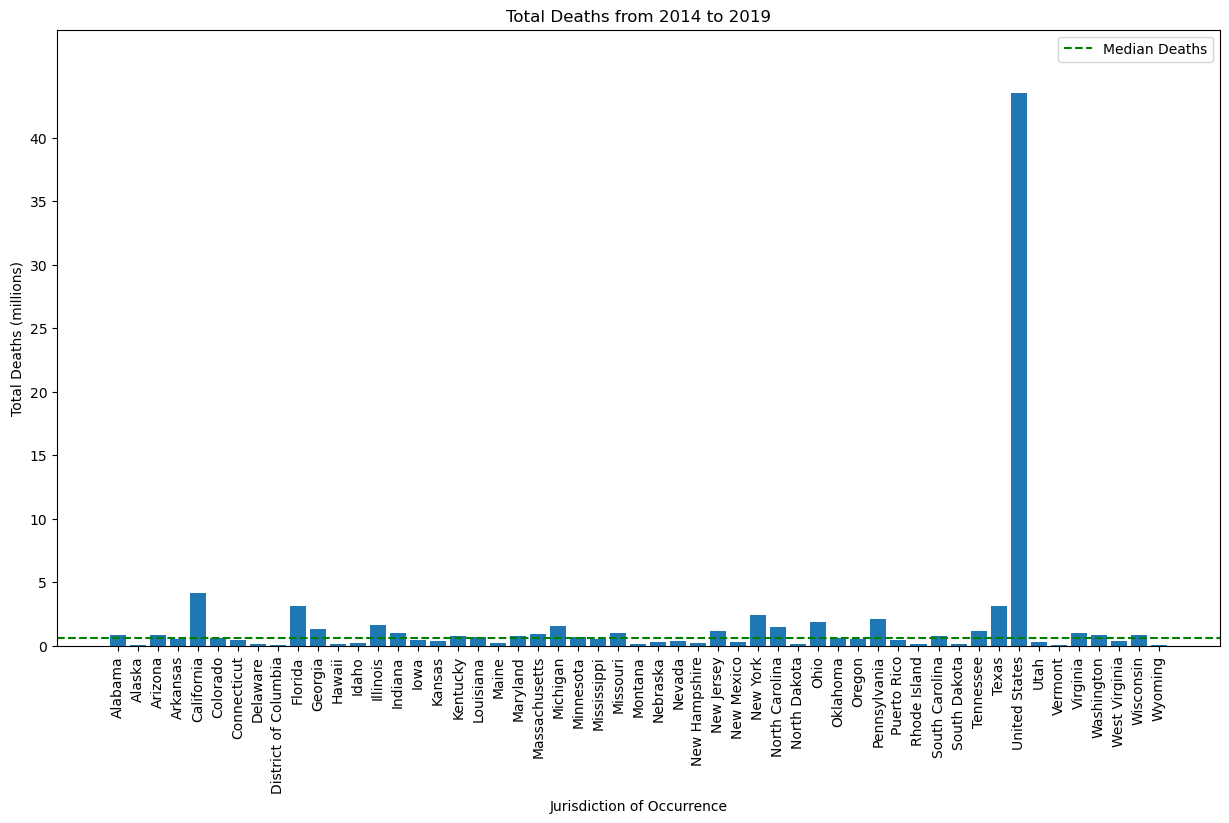

In [6]:
# EDA

# Yearly Deaths barplot by States

print('f{YearlyDeaths.isna().sum()}')

# Adjust the figure size as needed
plt.figure(figsize=(15, 8))

# Remove non-integer values from Total Deaths
YearlyDeaths_clean = YearlyDeaths.dropna()
print(YearlyDeaths_clean.head(5))

#Calculating Total Deaths from year 2014 to 2019
Final_Death_cal = YearlyDeaths_clean.groupby('Jurisdiction of Occurrence')['Total Deaths'].sum().to_frame(name='Grand Total of Deaths').reset_index()
print(Final_Death_cal.head(5))
#print(Final_Death_cal[Final_Death_cal['Jurisdiction of Occurrence']=='United States'])


# Plotting barplot
plt.bar(Final_Death_cal['Jurisdiction of Occurrence'], Final_Death_cal['Grand Total of Deaths'] / 10**6)

# Set labels and title
plt.xlabel('Jurisdiction of Occurrence')
plt.ylabel('Total Deaths (millions)')
plt.title('Total Deaths from 2014 to 2019')

# Adding deaths median line
plt.axhline(Final_Death_cal['Grand Total of Deaths'].median() / 10**6, color='Green', linestyle='--', label='Median Deaths')

# Add legend
plt.legend()

# Set X labels 90 degrees for better visibility
plt.xticks(rotation=90)

# Limiting Y values
plt.ylim(0, max(Final_Death_cal['Grand Total of Deaths'] / 10**6) + 5)

# Setting Y ticks
plt.yticks(range(0, int(max(Final_Death_cal['Grand Total of Deaths'] / 10**6)) + 1, 5))

plt.show()


In [7]:
# ETL-3
# How many deaths per 100,000 in the respective states

# Read population dataset
State_popu = pd.read_excel('/users/nikhildeshpande/documents/python/nst-est2019-01.xlsx')
print('\nColumns of State population dataframe:')
print(State_popu.columns)
print('\nHead of the Dataframe')
print(State_popu.head(5))

# Delete Estimate base column as it's not useful in the analysis
State_popu = State_popu.drop(columns=['Census', 'Estimates Base', 2010, 2011, 2012, 2013])

print('\nUpdated State Population dataframe:')
print(State_popu.head(5), end='\n\n')


# Reshaping Dataset to merge with Population Dataset
YearlyDeaths = YearlyDeaths.pivot_table(values='Total Deaths', index='Jurisdiction of Occurrence', columns='MMWR Year')
print('Reshaping YearlyDeaths to merge with Population Dataset\n')
print(YearlyDeaths.head(5), end='\n\n')

YearlyDeaths.to_csv("/users/nikhildeshpande/documents/python/Population_deaths.csv")

# Merge and verify the dataset

Death_Popu = YearlyDeaths.merge(State_popu,
                                left_on="Jurisdiction of Occurrence",
                                right_on="Demographics", how='inner',
                                suffixes=('_Deaths', '_Population'))

# Add a new column deaths per 100000 to calculate deaths per 100000

# Calculate deaths per 100000 for each year
for year in range(2014, 2020):
    Death_Popu[f'{year}_Deaths_per_100000'] = round((Death_Popu[f'{year}_Deaths'] / Death_Popu[f'{year}_Population'])
                                                    * 100000)

print('Deaths per 100,000\n')
print(Death_Popu.head(8))
    
    
Death_Popu.to_csv("/users/nikhildeshpande/documents/python/death_pop.csv")




Columns of State population dataframe:
Index([  'Demographics',         'Census', 'Estimates Base',             2010,
                   2011,             2012,             2013,             2014,
                   2015,             2016,             2017,             2018,
                   2019],
      dtype='object')

Head of the Dataframe
    Demographics     Census  Estimates Base       2010       2011       2012  \
0  United States  308745538       308758105  309321666  311556874  313830990   
1        Alabama    4779736         4780125    4785437    4799069    4815588   
2         Alaska     710231          710249     713910     722128     730443   
3        Arizona    6392017         6392288    6407172    6472643    6554978   
4       Arkansas    2915918         2916031    2921964    2940667    2952164   

        2013       2014       2015       2016       2017       2018       2019  
0  315993715  318301008  320635163  322941311  324985539  326687501  328239523  
1    4830

In [8]:
# States with the highest population 

# Sort the dataset by the highest population
Highest_pop = Death_Popu.copy()

# Calculate and round Mean Popu
Highest_pop.loc[:, 'Mean Popu'] = round(Highest_pop[['2014_Population','2015_Population','2016_Population','2017_Population','2018_Population','2019_Population']].mean(axis=1))

# Calculate and round Mean Deaths
Highest_pop.loc[:, 'Mean Deaths'] = round(Highest_pop[['2014_Deaths','2015_Deaths','2016_Deaths','2017_Deaths','2018_Deaths','2019_Deaths']].mean(axis=1))

# Calculate and round Mean Deaths per 100,000
Highest_pop.loc[:, 'Mean Deaths per 100000'] = round(Highest_pop[['2014_Deaths_per_100000','2015_Deaths_per_100000','2016_Deaths_per_100000','2017_Deaths_per_100000','2018_Deaths_per_100000','2019_Deaths_per_100000']].mean(axis=1))


#Top 10 populus states
top_pop = Highest_pop.sort_values(by= 'Mean Popu', ascending=False)

#Omitting USA
Populus_States = top_pop.iloc[1:11]

print(tabulate(Populus_States[['Demographics','Mean Popu']], headers=['Demographics','Population'], showindex=False, floatfmt=".0f"))
      

Demographics      Population
--------------  ------------
California          39169074
Texas               28044770
Florida             20725683
New York            19585438
Pennsylvania        12790994
Illinois            12789609
Ohio                11646615
Georgia             10347750
North Carolina      10209542
Michigan             9959363


In [9]:
# States with the highest mortality rate
top_mor = Highest_pop.sort_values(by='Mean Deaths per 100000', ascending=False)


#Top 10 high Mortality rate states
top_mor_state = top_mor.iloc[0:10]
print(tabulate(top_mor_state[['Demographics','Mean Deaths per 100000']], headers=['Demographics','Deaths per 100000'], showindex=False, floatfmt=".0f"))

#What is the country avg of Deaths per 100000
Country_ave_deaths100000 = round(top_mor['Mean Deaths per 100000'].mean())
print(f'\nThe national average of deaths per 100000 is:{Country_ave_deaths100000}')


Demographics      Deaths per 100000
--------------  -------------------
West Virginia                  3120
Tennessee                      2828
Alabama                        2818
Kentucky                       2778
Mississippi                    2756
Arkansas                       2754
Pennsylvania                   2752
Ohio                           2716
Missouri                       2712
Maine                          2675

The national average of deaths per 100000 is:2276


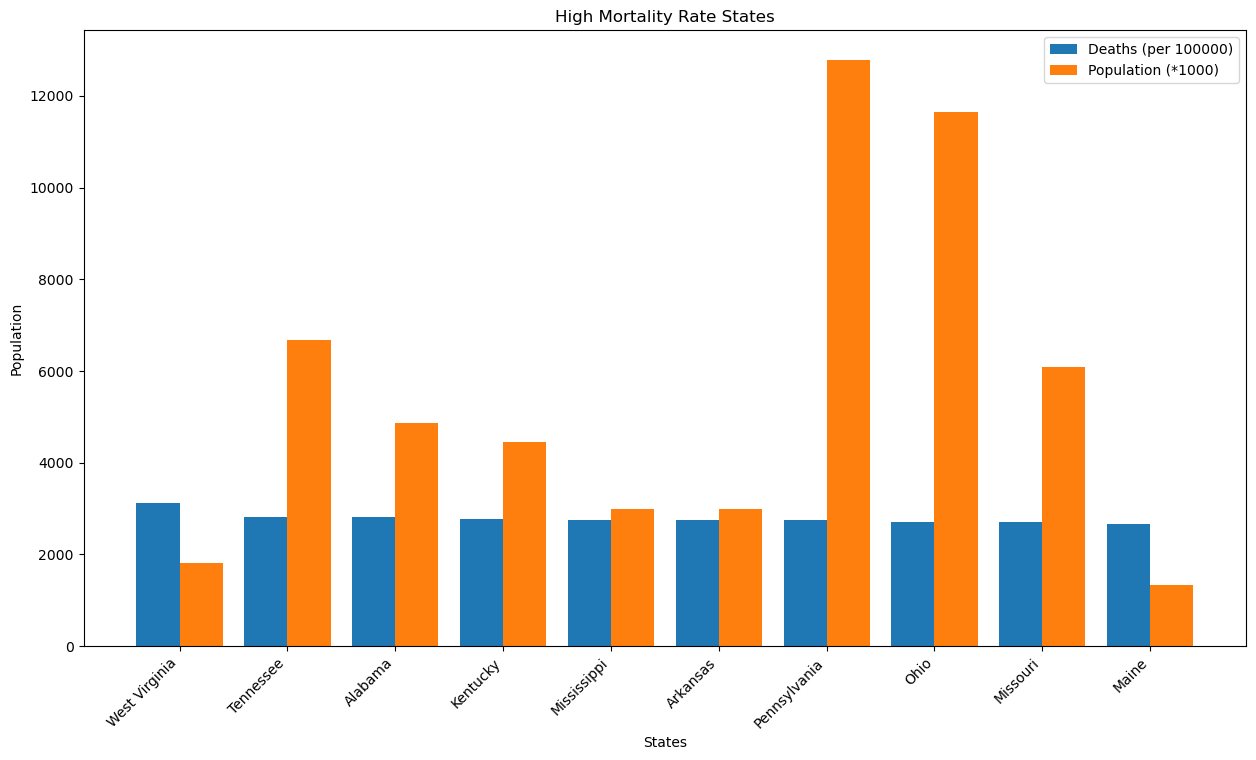

In [10]:
#Mortality rate visualization

# Extract the data
xbar = top_mor_state['Demographics']
Deaths = top_mor_state[['Mean Deaths per 100000']]
Popu = top_mor_state[['Mean Popu']]

x_axis = np.arange(len(xbar))

# Create the bar plot for Deaths
plt.figure(figsize=(15,8))
plt.bar(x_axis - 0.2, Deaths['Mean Deaths per 100000'], width=0.4, label='Deaths (per 100000)')
plt.bar(x_axis + 0.2, Popu['Mean Popu'] / 1000, width=0.4, label='Population (*1000)')

#Rotate X-axis names
plt.xticks(x_axis, xbar, rotation=45, ha="right")

#Plot Title
plt.title("High Mortality Rate States")
plt.xlabel("States")
plt.ylabel("Population")


# Add legend
plt.legend()

# Display
plt.show()


In [12]:

# Machine Learning to predict Deaths by various Causes

WorkData = pd.get_dummies(WorkData)

ML_WorkData = WorkData.drop(columns=['MMWR Week','Weekly Total Deaths'])
ML_WorkData.columns


#Define your feature columns (X) and target variable (y)

X = ML_WorkData.drop(columns=['All  Cause', 'Natural Cause', 'Septicemia (A40-A41)',
       'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)',
       'Alzheimer disease (G30)', 'Influenza and pneumonia (J10-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)'])


y = ML_WorkData[['All  Cause', 'Natural Cause', 'Septicemia (A40-A41)',
       'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)',
       'Alzheimer disease (G30)', 'Influenza and pneumonia (J10-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)']]


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared value of Random Forest Regressor: {r2}')

# Decision Tree
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error of Decision Tree: {mse}')
print(f'R-squared value of Decision Tree: {r2}')



Mean Squared Error: 7822.332079714523
R-squared value of Random Forest Regressor: 0.9887139645991828
Mean Squared Error of Decision Tree: 11075.003440827808
R-squared value of Decision Tree: 0.9847740920982323
